## importing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, Flatten, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2022-12-02 15:03:27.964159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:03:29.366382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 15:03:29.366437: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 15:03:33.390394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## loading data

### loading train data

In [2]:
# loading feature data 
data_features=pd.read_csv('../raw_data/dengue_features_train.csv')
# loading outcome data
data_outcome=pd.read_csv('../raw_data/dengue_labels_train.csv')
# merging two data sets
data=data_features.merge(data_outcome)

### splitting train data 

In [4]:
sj_data = data[data['city'] == 'sj']
sj_data = sj_data.drop('city', axis=1)

iq_data = data[data['city'] == 'iq']
iq_data = iq_data.drop('city', axis=1)

### loading test data

In [3]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')
# splitting test data according to city
sj_test = testing_data[testing_data.city=='sj'].copy()
iq_test = testing_data[testing_data.city=='iq'].copy()

## preprocessing data

In [5]:
# filling missing values with previous value
iq_data.fillna(method='ffill', inplace=True)
sj_data.fillna(method='ffill', inplace=True)

In [6]:
def preprocess(rawfeats,train=True):
    
    #reset index to prevent issues when merging
    reindexed_data = rawfeats.reset_index(drop = True)
    
    #fill nas with interpolation
    feats = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)

    #merge back together
    non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'total_cases']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [7]:
iq_data = preprocess(iq_data)
sj_data = preprocess(sj_data)

In [8]:
# splitting train data into X and y
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data['total_cases']
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data['total_cases']

In [9]:
# splitting train data into train and test sets for sj
sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_y_train = sj_y.head(702)
sj_y_test = sj_y.tail(234)
print(sj_X_train.shape)
print(sj_y_test.shape)

(702, 12)
(234,)


In [10]:
# splitting train data into train and test sets for iq
iq_X_train = iq_X.head(490)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(490)
iq_y_test = iq_y.tail(130)
print(iq_X_train.shape)
print(iq_y_train.shape)

(490, 12)
(490,)


## Transforming data into sequences

### for train data

In [19]:
# Create training sequences for sj
sj_train_sequences = TimeseriesGenerator(sj_X_train, 
                                      sj_y_train.values, 
                                      length=7, 
                                      batch_size=1)

# Create test sequences
sj_test_sequences = TimeseriesGenerator(sj_X_test, 
                                     sj_y_test.values, 
                                     length=7, 
                                     batch_size=1)

# Create full sequences for sj
sj_full_sequences = TimeseriesGenerator(sj_X, 
                                      sj_y.values, 
                                      length=7, 
                                      batch_size=1)

In [20]:
# Create training sequences for iq
iq_train_sequences = TimeseriesGenerator(iq_X_train, 
                                      iq_y_train.values, 
                                      length=7, 
                                      batch_size=1)

# Create test sequences
iq_test_sequences = TimeseriesGenerator(iq_X_test, 
                                     iq_y_test.values, 
                                     length=7, 
                                     batch_size=1)
# Create full sequences for iq
iq_full_sequences = TimeseriesGenerator(iq_X, 
                                      iq_y.values, 
                                      length=7, 
                                      batch_size=1)

### for test data

In [30]:
def preprocess2(rawfeats,train=True):
    
    #reset index to prevent issues when merging
    reindexed_data = rawfeats.reset_index(drop = True)
    
    #fill nas with interpolation
    feats = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)

    #merge back together
    non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [31]:
sj_test = preprocess2(sj_test,train=False)
iq_test = preprocess2(iq_test,train=False)

In [32]:
# Create test sequences for sj
sj_actual_test_sequences = TimeseriesGenerator(sj_test, 
                                      sj_test.values, 
                                      length=7, 
                                      batch_size=1)
# Create test sequences for iq
iq_actual_test_sequences = TimeseriesGenerator(iq_test,
                                        iq_test.values,
                                      length=7, 
                                      batch_size=1)

## RNN model

### RNN model design

In [15]:
def rnn_model():
    # Design RNN
    rnn_model = Sequential()
    # RNN Layers
    rnn_model.add(GRU(20, input_shape=(7, 12), 
              return_sequences=True)) 
    rnn_model.add(GRU(20, return_sequences=False))
    rnn_model.add(Dropout(0.25))
    # Hidden dense layer
    rnn_model.add(Dense(10, activation='relu'))
    rnn_model.add(Dropout(0.25))
    # Output layer
    rnn_model.add(Dense(1, activation='linear'))
    # Compile model
    rnn_model.compile(loss='mae', optimizer='adam',metrics = ['mae'])
    return rnn_model

### RNN model fit

In [16]:
# model fit for sj
sj_model_rnn = rnn_model()
sj_rnn_hist=sj_model_rnn.fit_generator(sj_train_sequences,epochs=40, verbose=1)

2022-12-02 15:25:13.378538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 15:25:13.379781: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 15:25:13.380424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (NB16-VHA): /proc/driver/nvidia/version does not exist
2022-12-02 15:25:13.384535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
695/695 [==============================] - 21s 20ms/step - loss: 29.6750 - mae: 29.6750
Epoch 2/40
695/695 [==============================] - 17s 25ms/step - loss: 27.5107 - mae: 27.5107
Epoch 3/40
695/695 [==============================] - 22s 32ms/step - loss: 26.8275 - mae: 26.8275
Epoch 4/40
695/695 [==============================] - 14s 20ms/step - loss: 26.6269 - mae: 26.6269
Epoch 5/40
695/695 [==============================] - 17s 25ms/step - loss: 26.2127 - mae: 26.2127
Epoch 6/40
695/695 [==============================] - 18s 25ms/step - loss: 26.1726 - mae: 26.1726
Epoch 7/40
695/695 [==============================] - 15s 22ms/step - loss: 26.0473 - mae: 26.0473
Epoch 8/40
695/695 [==============================] - 25s 36ms/step - loss: 25.6245 - mae: 25.6245
Epoch 9/40
695/695 [==============================] - 21s 30ms/step - loss: 25.7027 - mae: 25.7027
Epoch 10/40
695/695 [==============================] - 23s 34ms/step - loss: 25.6396 - mae: 25.6396
Epoch 11/

In [17]:
# model fit for sj
iq_model_rnn = rnn_model()
iq_rnn_hist=iq_model_rnn.fit_generator(iq_train_sequences,epochs=40, verbose=1)

Epoch 1/40


/tmp/ipykernel_5826/3353771620.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  iq_rnn_hist=iq_model_rnn.fit_generator(iq_train_sequences,epochs=40, verbose=1)


483/483 [==============================] - 31s 27ms/step - loss: 6.4411 - mae: 6.4411
Epoch 2/40
483/483 [==============================] - 13s 26ms/step - loss: 6.1843 - mae: 6.1843
Epoch 3/40
483/483 [==============================] - 14s 29ms/step - loss: 6.2832 - mae: 6.2832
Epoch 4/40
483/483 [==============================] - 11s 22ms/step - loss: 6.1965 - mae: 6.1965
Epoch 5/40
483/483 [==============================] - 11s 22ms/step - loss: 6.1028 - mae: 6.1028
Epoch 6/40
483/483 [==============================] - 13s 27ms/step - loss: 6.1222 - mae: 6.1222
Epoch 7/40
483/483 [==============================] - 14s 28ms/step - loss: 6.0711 - mae: 6.0711
Epoch 8/40
483/483 [==============================] - 16s 33ms/step - loss: 6.0931 - mae: 6.0931
Epoch 9/40
483/483 [==============================] - 12s 24ms/step - loss: 5.9733 - mae: 5.9733
Epoch 10/40
483/483 [==============================] - 10s 21ms/step - loss: 6.0129 - mae: 6.0129
Epoch 11/40
483/483 [===================

### evaluate model

In [23]:
sj_rnn_model_evaluate= sj_model_rnn.evaluate(sj_test_sequences)

227/227 [==============================] - 2s 8ms/step - loss: 16.4854 - mae: 16.4854


In [24]:
iq_rnn_model_evaluate= iq_model_rnn.evaluate(iq_test_sequences)

123/123 [==============================] - 7s 7ms/step - loss: 6.4227 - mae: 6.4227


In [33]:
# Get predictions for rnn sj
sj_rnn_train_preds = sj_model_rnn.predict(sj_full_sequences)
sj_rnn_test_preds = sj_model_rnn.predict(sj_actual_test_sequences)

253/253 [==============================] - 10s 9ms/step


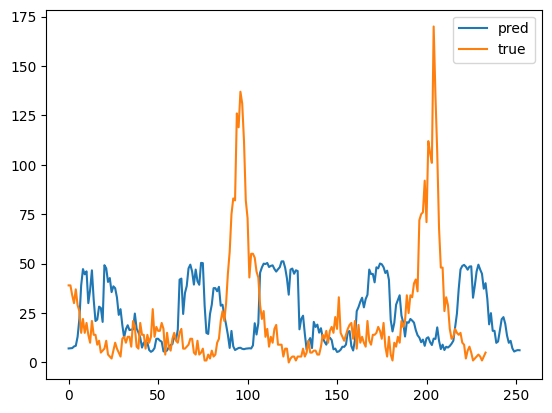

In [35]:
plt.plot(sj_rnn_test_preds, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.show;

In [36]:
# Get predictions for rnn iq
iq_rnn_train_preds = iq_model_rnn.predict(iq_full_sequences)
iq_rnn_test_preds = iq_model_rnn.predict(iq_actual_test_sequences)

149/149 [==============================] - 2s 7ms/step


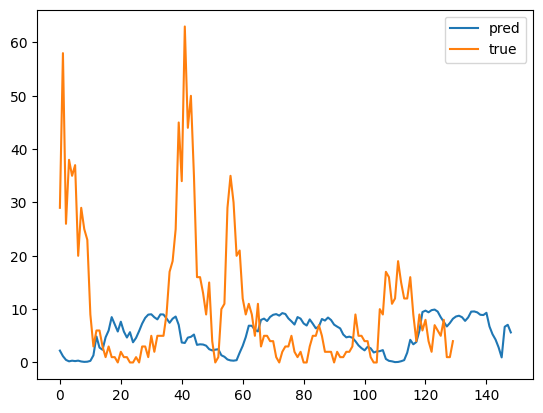

In [37]:
plt.plot(iq_rnn_test_preds, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.show;

## LSTM model

### LSTM model design

In [38]:
def lstm_model():
    model_lstm = Sequential()
    # LSTM Layer 
    model_lstm.add(LSTM(units=60, return_sequences=True, input_shape=(7,12)))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(40, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(20, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(8, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(4, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Output layer
    model_lstm.add(Dense(1, activation='linear'))

    # compile model
    model_lstm.compile(loss='mae', optimizer='rmsprop', metrics = ['mae'])
    
    return model_lstm

In [40]:
sj_model_lstm = lstm_model()
sj_model_lstm.fit_generator(sj_train_sequences,epochs=40, verbose=1)

Epoch 1/40


/tmp/ipykernel_5826/2170332389.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  sj_model_lstm.fit_generator(sj_train_sequences,epochs=40, verbose=1)


695/695 [==============================] - 16s 15ms/step - loss: 31.1846 - mae: 31.1846
Epoch 2/40
695/695 [==============================] - 10s 14ms/step - loss: 29.4071 - mae: 29.4070
Epoch 3/40
695/695 [==============================] - 10s 14ms/step - loss: 28.7077 - mae: 28.7076
Epoch 4/40
695/695 [==============================] - 12s 17ms/step - loss: 28.1241 - mae: 28.1241
Epoch 5/40
695/695 [==============================] - 12s 17ms/step - loss: 28.1893 - mae: 28.1893
Epoch 6/40
695/695 [==============================] - 11s 16ms/step - loss: 28.1130 - mae: 28.1130
Epoch 7/40
695/695 [==============================] - 16s 23ms/step - loss: 27.5258 - mae: 27.5258
Epoch 8/40
695/695 [==============================] - 11s 15ms/step - loss: 27.5080 - mae: 27.5080
Epoch 9/40
695/695 [==============================] - 11s 16ms/step - loss: 27.2896 - mae: 27.2896
Epoch 10/40
695/695 [==============================] - 14s 20ms/step - loss: 27.0266 - mae: 27.0266
Epoch 11/40
695/695 

In [44]:
# Get predictions
sj_lstm_train_preds = sj_model_lstm.predict(sj_full_sequences)
sj_lstm_test_preds = sj_model_lstm.predict(sj_test_sequences)

227/227 [==============================] - 2s 10ms/step


In [59]:
# We now evaluate on the test data for sj
print(sj_model_lstm.evaluate(sj_actual_test_sequences, verbose=0))

InvalidArgumentError: Graph execution error:

Detected at node 'mean_absolute_error/sub' defined at (most recent call last):
    File "/root/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/root/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/root/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/root/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/root/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5826/264134842.py", line 2, in <module>
      print(sj_model_lstm.evaluate(sj_actual_test_sequences, verbose=0))
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/root/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/keras/losses.py", line 1641, in mean_absolute_error
      return backend.mean(tf.abs(y_pred - y_true), axis=-1)
Node: 'mean_absolute_error/sub'
Incompatible shapes: [1,7] vs. [1,12]
	 [[{{node mean_absolute_error/sub}}]] [Op:__inference_test_function_464391]

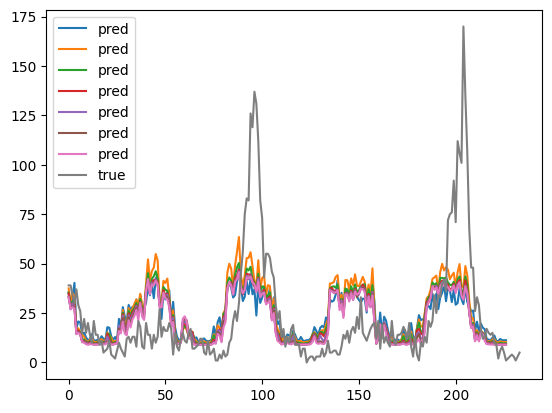

In [46]:
sj_lstm_test_preds=sj_lstm_test_preds.reshape(227,7)
plt.plot(sj_lstm_test_preds, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.show;

In [41]:
iq_model_lstm = lstm_model()
iq_model_lstm.fit_generator(iq_full_sequences ,epochs=40, verbose=1)

/tmp/ipykernel_5826/530245782.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  iq_model_lstm.fit_generator(iq_full_sequences ,epochs=40, verbose=1)


Epoch 1/40
513/513 [==============================] - 56s 26ms/step - loss: 6.9175 - mae: 6.9175
Epoch 2/40
513/513 [==============================] - 11s 21ms/step - loss: 6.5961 - mae: 6.5961
Epoch 3/40
513/513 [==============================] - 9s 18ms/step - loss: 6.3556 - mae: 6.3556
Epoch 4/40
513/513 [==============================] - 9s 18ms/step - loss: 6.3686 - mae: 6.3686
Epoch 5/40
513/513 [==============================] - 9s 18ms/step - loss: 6.2763 - mae: 6.2763
Epoch 6/40
513/513 [==============================] - 9s 17ms/step - loss: 6.2021 - mae: 6.2021
Epoch 7/40
513/513 [==============================] - 16s 31ms/step - loss: 6.1687 - mae: 6.1687
Epoch 8/40
513/513 [==============================] - 10s 19ms/step - loss: 6.1497 - mae: 6.1497
Epoch 9/40
513/513 [==============================] - 9s 17ms/step - loss: 6.1536 - mae: 6.1536
Epoch 10/40
513/513 [==============================] - 10s 20ms/step - loss: 6.0935 - mae: 6.0935
Epoch 11/40
513/513 [=============

In [49]:
# Get predictions
iq_lstm_train_preds = iq_model_lstm.predict(iq_full_sequences)
iq_lstm_test_preds = iq_model_lstm.predict(iq_test_sequences)

123/123 [==============================] - 1s 6ms/step


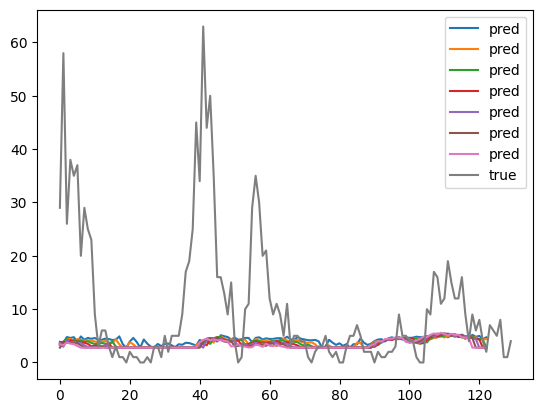

In [52]:
iq_lstm_test_preds=iq_lstm_test_preds.reshape(123,7)
plt.plot(iq_lstm_test_preds, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.show;

## CNN model

### additional preprocess for cnn model

In [53]:
# Expand dimensions for CNN for sj
sj_X_train_cnn = np.expand_dims(sj_X_train, axis=2)
sj_X_test_cnn = np.expand_dims(sj_X_test, axis=2)
sj_X_train_full_cnn = np.expand_dims(sj_X, axis=2)

# Expand dimensions for CNN for iq
iq_X_train_cnn = np.expand_dims(iq_X_train, axis=2)
iq_X_test_cnn = np.expand_dims(iq_X_test, axis=2)
iq_X_train_full_cnn = np.expand_dims(iq_X, axis=2)

### CNN model design

In [54]:
# Function to gridsearch cnn
def cnn_function(kernel = 7, pool = 1, drop = 0.25, hidden = 64):
    # Design CNN
    cnn_model = Sequential()
    # CNN Layers 
    cnn_model.add(Conv1D(filters = 12,       
                     kernel_size = kernel,  
                     activation = 'relu',   
                     input_shape = (12,1))) 
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(drop))
    # Hidden dense layer
    cnn_model.add(Dense(hidden, activation='relu'))
    cnn_model.add(Dropout(drop))
    # Output layer
    cnn_model.add(Dense(1, activation='linear'))
    # Compile Model
    cnn_model.compile(loss='mae', optimizer='adam', metrics = ['mae'])
    # return model
    return cnn_model

### CNN model fit

In [56]:
cnn=cnn_function()
# fit model
cnn.fit(sj_X_train_cnn, sj_y_train)

22/22 [==============================] - 2s 6ms/step - loss: 37.5657 - mae: 37.5657


In [57]:
cnn.evaluate(sj_X_test, sj_y_test)

8/8 [==============================] - 1s 6ms/step - loss: 21.4571 - mae: 21.4571


[21.457101821899414, 21.457101821899414]

In [58]:
# Get predictions
sj_cnn_train_preds = cnn.predict(sj_X_train, sj_y_train)
sj_cnn_test_preds = cnn.predict(sj_X_test, sj_y_test)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().